# Setup

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap.umap_ as umap # !pip3 install umap-learn
from umap import UMAP

In [2]:
X_train = pd.read_csv('X_train.csv', index_col=0, header=[0, 1, 2])
y_train = pd.read_csv('y_train.csv', index_col=0)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())

X_train, X_temp, Y_train, Y_temp = train_test_split(X_train, y_train_encoded, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Y_train_encoded = label_encoder.fit_transform(Y_train.ravel())
Y_val_encoded = label_encoder.fit_transform(Y_val.ravel())
Y_test_encoded = label_encoder.fit_transform(Y_test.ravel())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# PCA

In [3]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
idx_full_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0]
idx_full_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0]

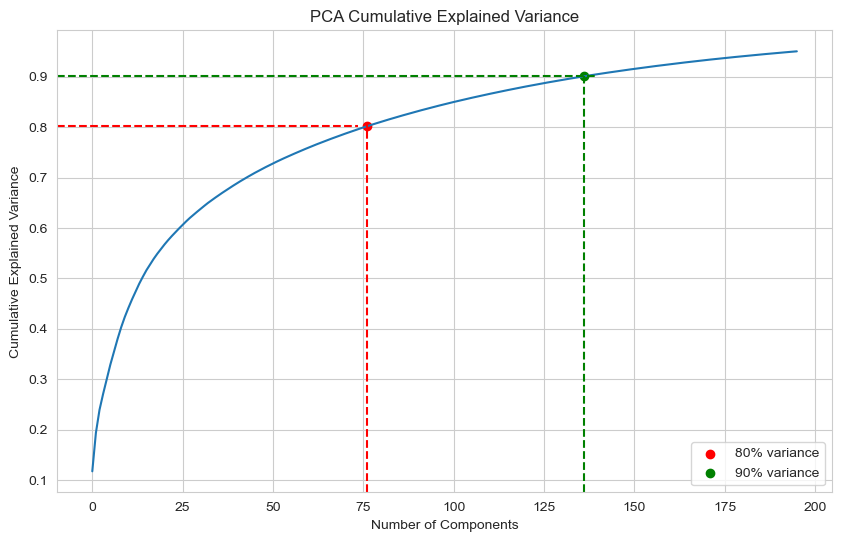

In [4]:
plt.figure(figsize=(10, 6))

# Plot the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.yticks(np.arange(0, 1, step=0.1))

y_80 = cumulative_variance[idx_full_80]
y_90 = cumulative_variance[idx_full_90]
plt.axvline(x=idx_full_80, ymax=y_80, color='red', linestyle='--')
plt.axhline(y=y_80, xmax=idx_full_80/len(cumulative_variance), color='red', linestyle='--')
plt.axvline(x=idx_full_90, ymax=y_90, color='green', linestyle='--')
plt.axhline(y=y_90, xmax=idx_full_90/len(cumulative_variance), color='green', linestyle='--')
plt.scatter(idx_full_80, y_80, color='red', label='80% variance')
plt.scatter(idx_full_90, y_90, color='green', label='90% variance')

plt.legend(loc='best')
plt.show()

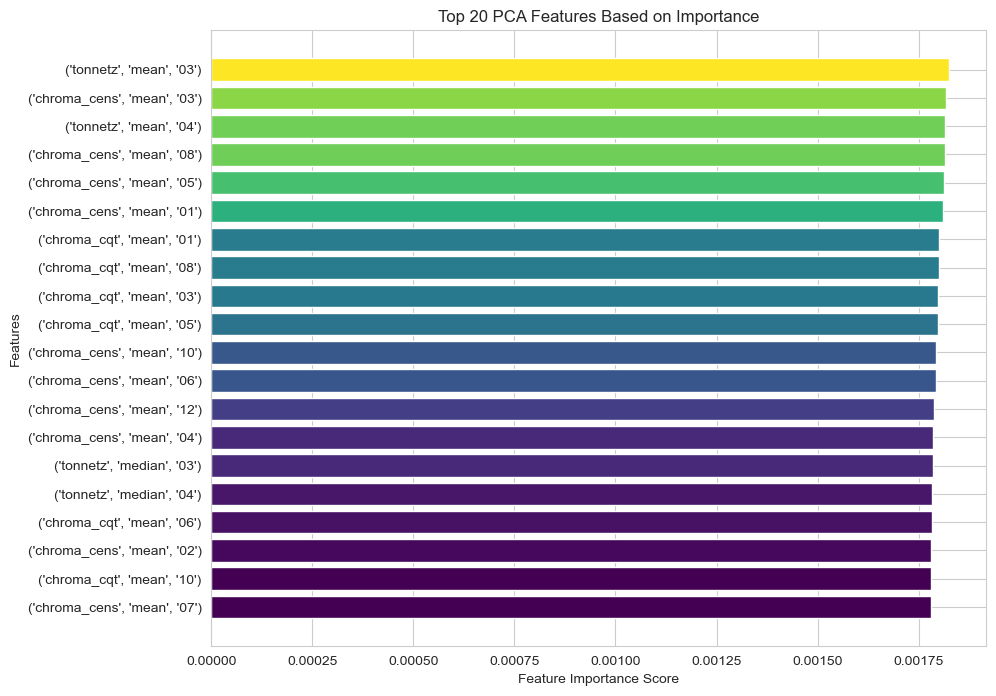

In [12]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_train_scaled)

squared_loadings = np.square(pca.components_)
contributions = squared_loadings * pca.explained_variance_ratio_[:, np.newaxis]
feature_contributions = np.sum(contributions, axis=0)
top_feature_indices = feature_contributions.argsort()[::-1][:20]
feature_names = X_train.columns.tolist()
top_feature_indices = top_feature_indices.tolist()
top_feature_names = [feature_names[i] for i in top_feature_indices]
top_feature_scores = feature_contributions[top_feature_indices].tolist()

plt.figure(figsize=(10, 8))
norm = mcolors.Normalize(vmin=min(top_feature_scores), vmax=max(top_feature_scores))
colormap = plt.cm.viridis
bar_colors = colormap(norm(top_feature_scores))
plt.barh(range(len(top_feature_names)), top_feature_scores, color=bar_colors)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 20 PCA Features Based on Importance')
plt.yticks(range(len(top_feature_names)), top_feature_names)  # Set feature names as y-tick labels
plt.gca().invert_yaxis()  # Show the highest score at the top
plt.show()

# ANOVA F-Test

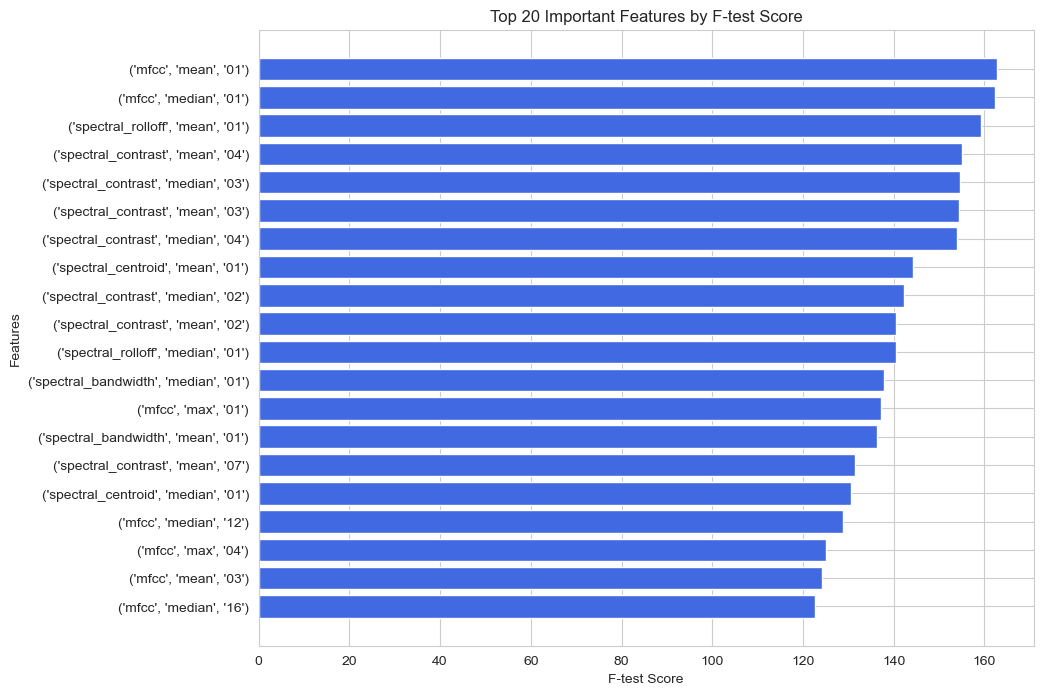

In [14]:
# Top 200 features
k = 200

# Create the SelectKBest with the ANOVA F-test
selector = SelectKBest(f_classif, k=k)
X_anova = selector.fit_transform(X_train_scaled, Y_train.ravel())

# Get top 20
selected_features_indices = selector.get_support(indices=True)
all_features_scores = selector.scores_
selected_features_scores = all_features_scores[selected_features_indices]
top_indices_sorted = np.argsort(selected_features_scores)[-20:][::-1]
top_scores = selected_features_scores[top_indices_sorted]
top_feature_indices = selected_features_indices[top_indices_sorted] 
top_feature_names = [feature_names[i] for i in top_feature_indices]

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(20), top_scores, color='royalblue')
plt.xlabel('F-test Score')
plt.ylabel('Features')
plt.title('Top 20 Important Features by F-test Score')
plt.yticks(range(20), top_feature_names)
plt.gca().invert_yaxis()  # Display the highest score at the top
plt.show()

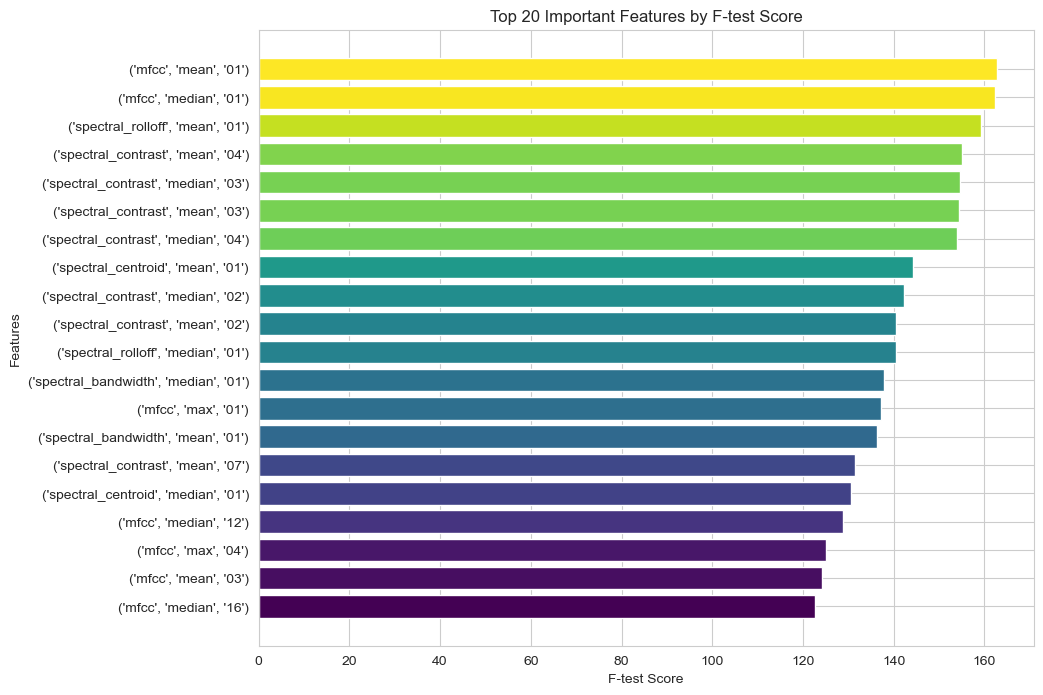

In [15]:
plt.figure(figsize=(10, 8))
norm = mcolors.Normalize(vmin=min(top_scores), vmax=max(top_scores))
colormap = plt.cm.viridis
bar_colors = colormap(norm(top_scores))
plt.barh(range(20), top_scores, color=bar_colors)
plt.xlabel('F-test Score')
plt.ylabel('Features')
plt.title('Top 20 Important Features by F-test Score')
plt.yticks(range(20), top_feature_names)
plt.gca().invert_yaxis()
plt.show()

# Recursive Feature Elimination (RFE) with a RandomForestClassifier

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=200, step=1)

rfe.fit(X_train_scaled, Y_train)

X_train_RF = rfe.transform(X_train_scaled)
X_test_RF = rfe.transform(X_test_scaled)

feature_rankings = rfe.ranking_
feature_importances = rfe.estimator_.feature_importances_

selected_features_indices = rfe.get_support(indices=True)
print(f"Selected feature indices: {selected_features_indices}")

Selected feature indices: [  1  21  81  85  89 108 166 178 196 202 205 207 208 209 210 213 214 215
 228 231 233 236 238 240 243 248 250 252 253 255 256 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 291 292 293 294
 295 296 297 298 301 303 305 307 308 309 310 311 312 313 314 315 316 317
 318 321 323 325 327 328 329 330 331 332 334 335 336 337 338 341 349 350
 351 352 353 354 355 356 357 358 361 363 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 397 398
 399 400 401 402 404 405 406 408 409 411 412 413 414 415 416 417 418 419
 420 423 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 454 455 457 458 459 460
 461 462 464 465 467 468 475 479 494 496 498 505 506 507 508 509 510 513
 514 517]


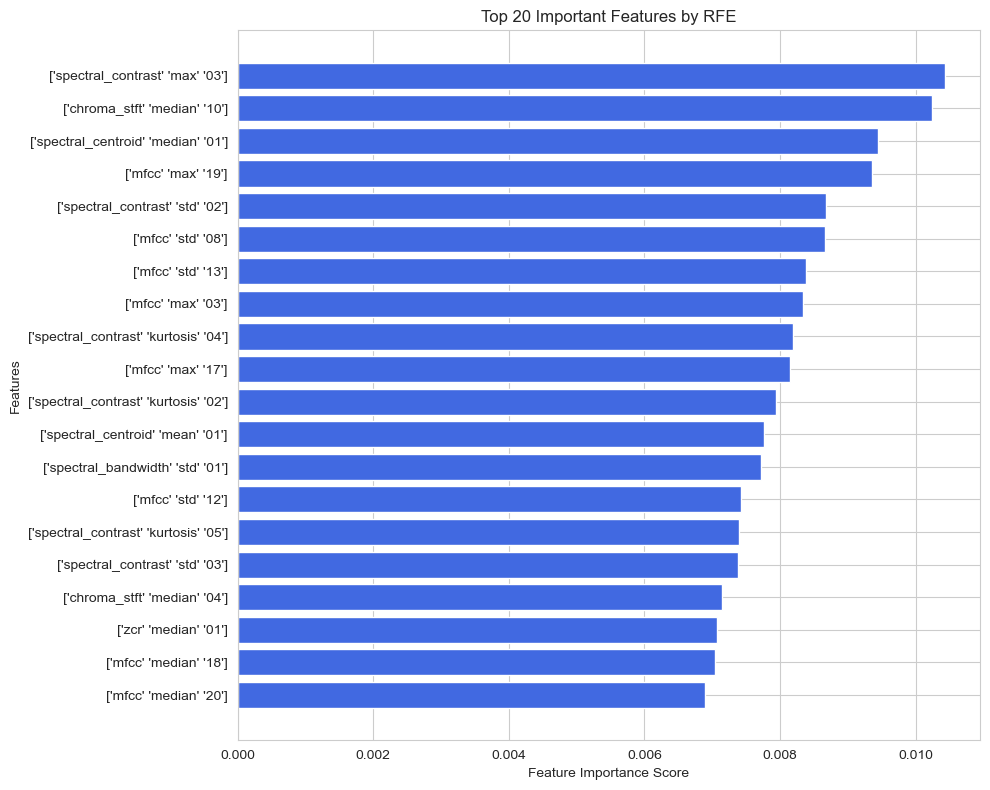

In [115]:
selected_feature_names = np.array(feature_names)[selected_features_indices]
top_20_idx = np.argsort(feature_importances)[-20:][::-1]
top_20_importances = feature_importances[top_20_idx]  
top_20_feature_names = selected_feature_names[top_20_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20_feature_names)), top_20_importances, color='royalblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Important Features by RFE')
plt.yticks(range(len(top_20_feature_names)), top_20_feature_names)
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.tight_layout()  # Adjust layout to fit feature names
plt.show()

# t-SNE

In [49]:
tsne = TSNE(n_components=2, perplexity=70, learning_rate=500, n_iter=3000, random_state=42)
tsne_pca = TSNE(n_components=2, perplexity=70, learning_rate=500, n_iter=3000, random_state=42)
tsne_anova = TSNE(n_components=2, perplexity=70, learning_rate=500, n_iter=3000, random_state=42)
tsne_RFE = TSNE(n_components=2, perplexity=70, learning_rate=500, n_iter=3000, random_state=42)

X_tsne = tsne.fit_transform(X_train_scaled)
X_tsne_pca = tsne.fit_transform(X_pca)
X_tsne_anova = tsne.fit_transform(scaler.fit_transform(X_anova))
X_tsne_RFE = tsne.fit_transform(X_train_RF)

genre_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
Y_train_genres = [genre_mapping[label] for label in Y_train.ravel()]

X_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
X_tsne['Genre'] = Y_train_genres

X_tsne_pca = pd.DataFrame(X_tsne_pca, columns=['tsne_1', 'tsne_2'])
X_tsne_pca['Genre'] = Y_train_genres

X_tsne_anova = pd.DataFrame(X_tsne_anova, columns=['tsne_1', 'tsne_2'])
X_tsne_anova['Genre'] = Y_train_genres

X_tsne_RFE = pd.DataFrame(X_tsne_RFE, columns=['tsne_1', 'tsne_2'])
X_tsne_RFE['Genre'] = Y_train_genres

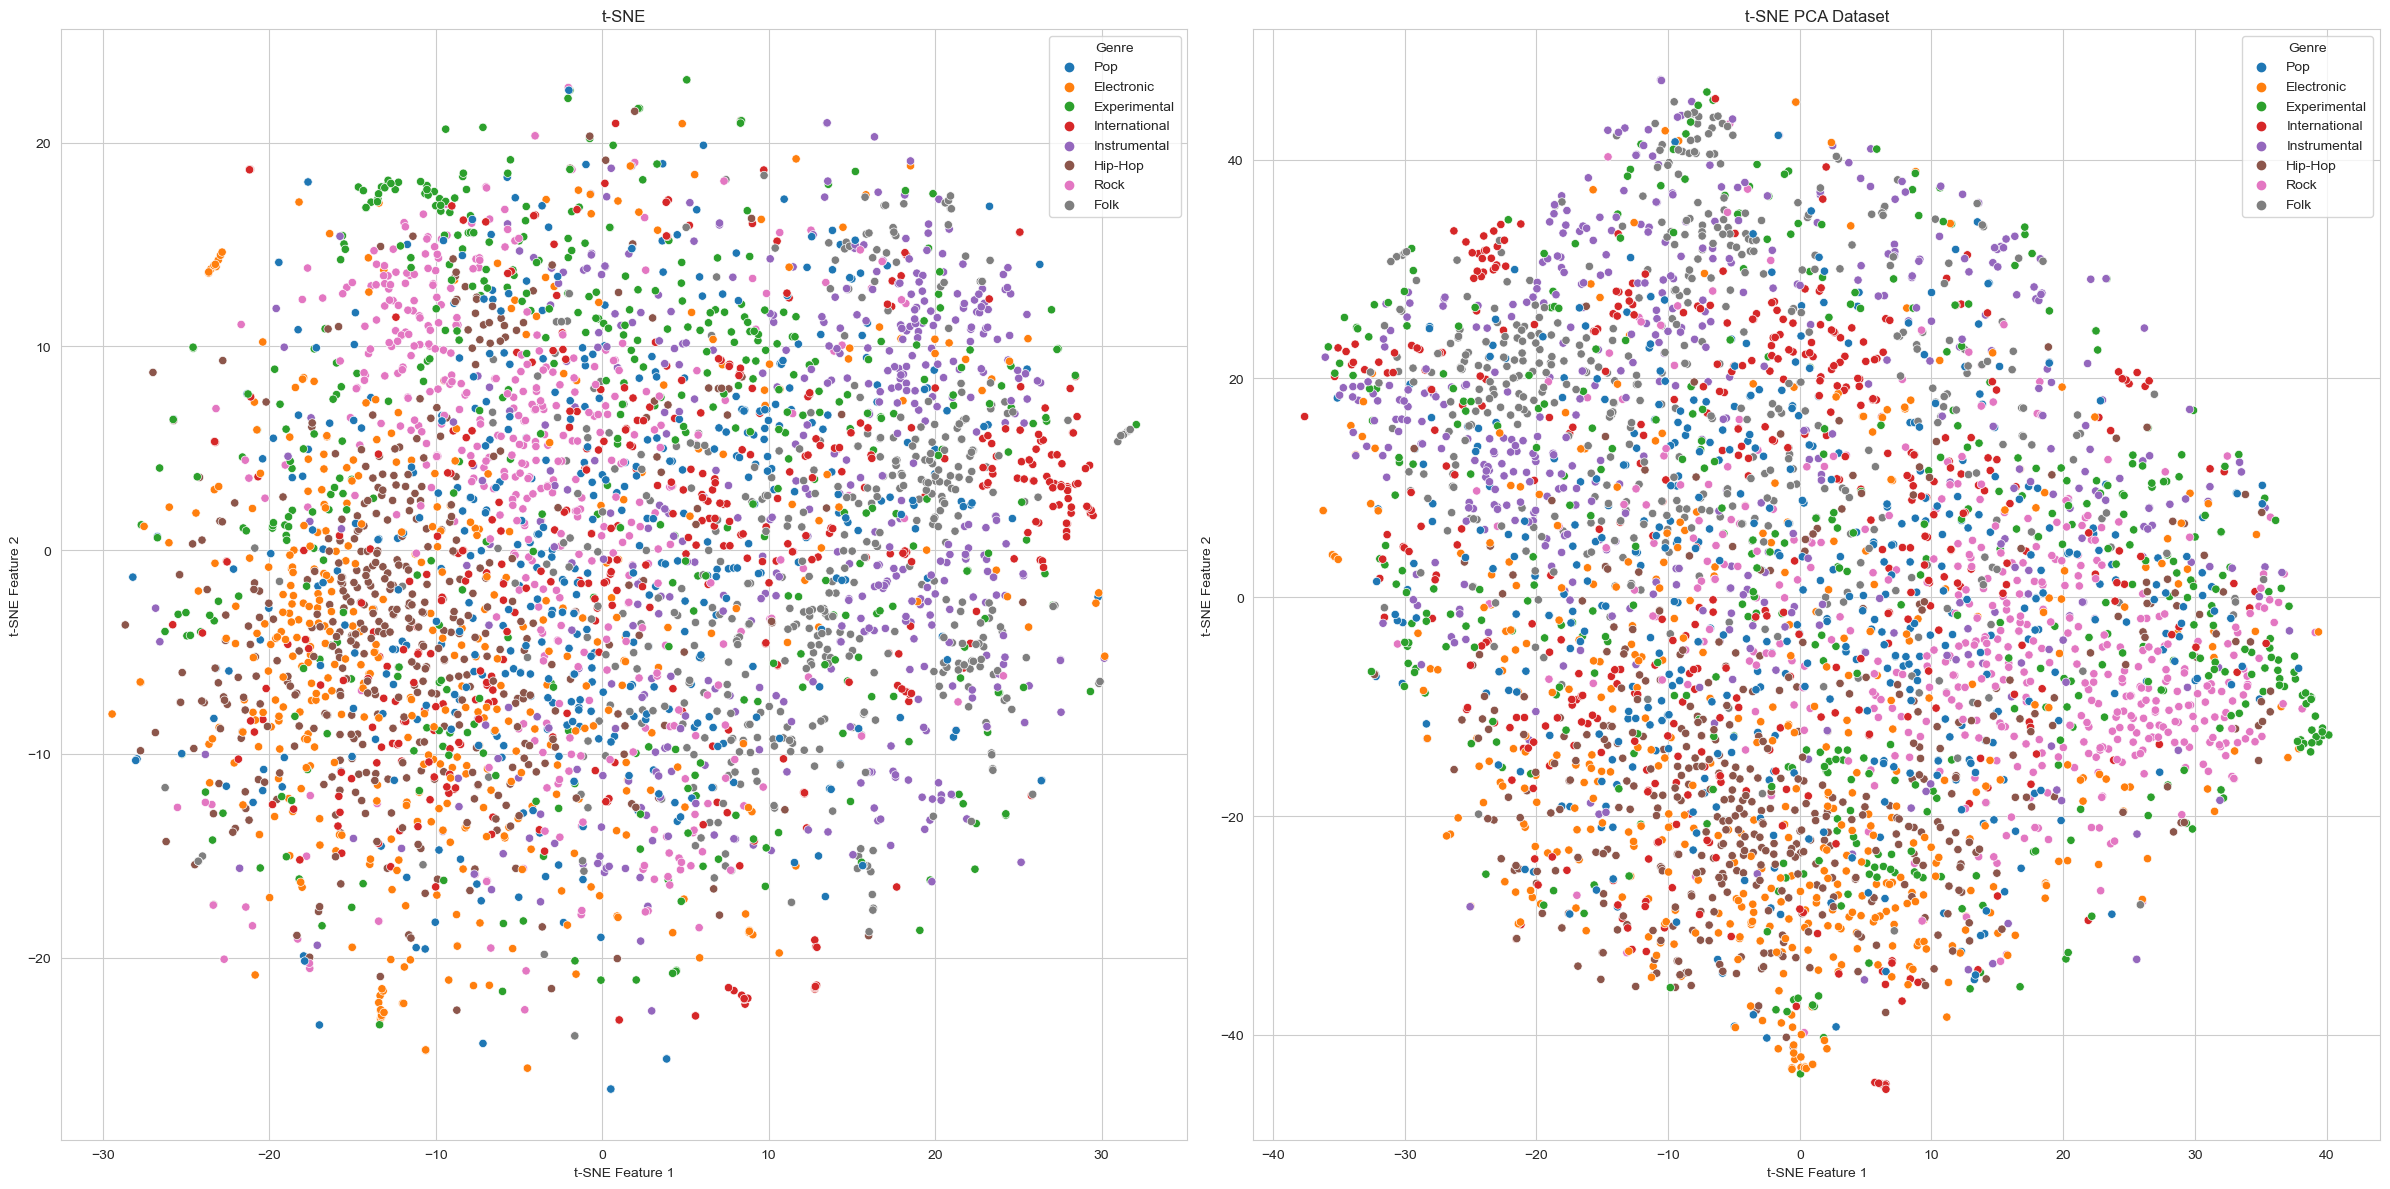

In [116]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot for the first dataset
sns.scatterplot(ax=axes[0], data=X_tsne, x='tsne_1', y='tsne_2', hue='Genre')
axes[0].set_title('t-SNE')
axes[0].set_xlabel('t-SNE Feature 1')
axes[0].set_ylabel('t-SNE Feature 2')
axes[0].legend(title='Genre')

# Plot for the second dataset
sns.scatterplot(ax=axes[1], data=X_tsne_pca, x='tsne_1', y='tsne_2', hue='Genre')
axes[1].set_title('t-SNE PCA Dataset')
axes[1].set_xlabel('t-SNE Feature 1')
axes[1].set_ylabel('t-SNE Feature 2')
axes[1].legend(title='Genre')

# Adjust layout so plots are spaced nicely
plt.tight_layout()
plt.show()

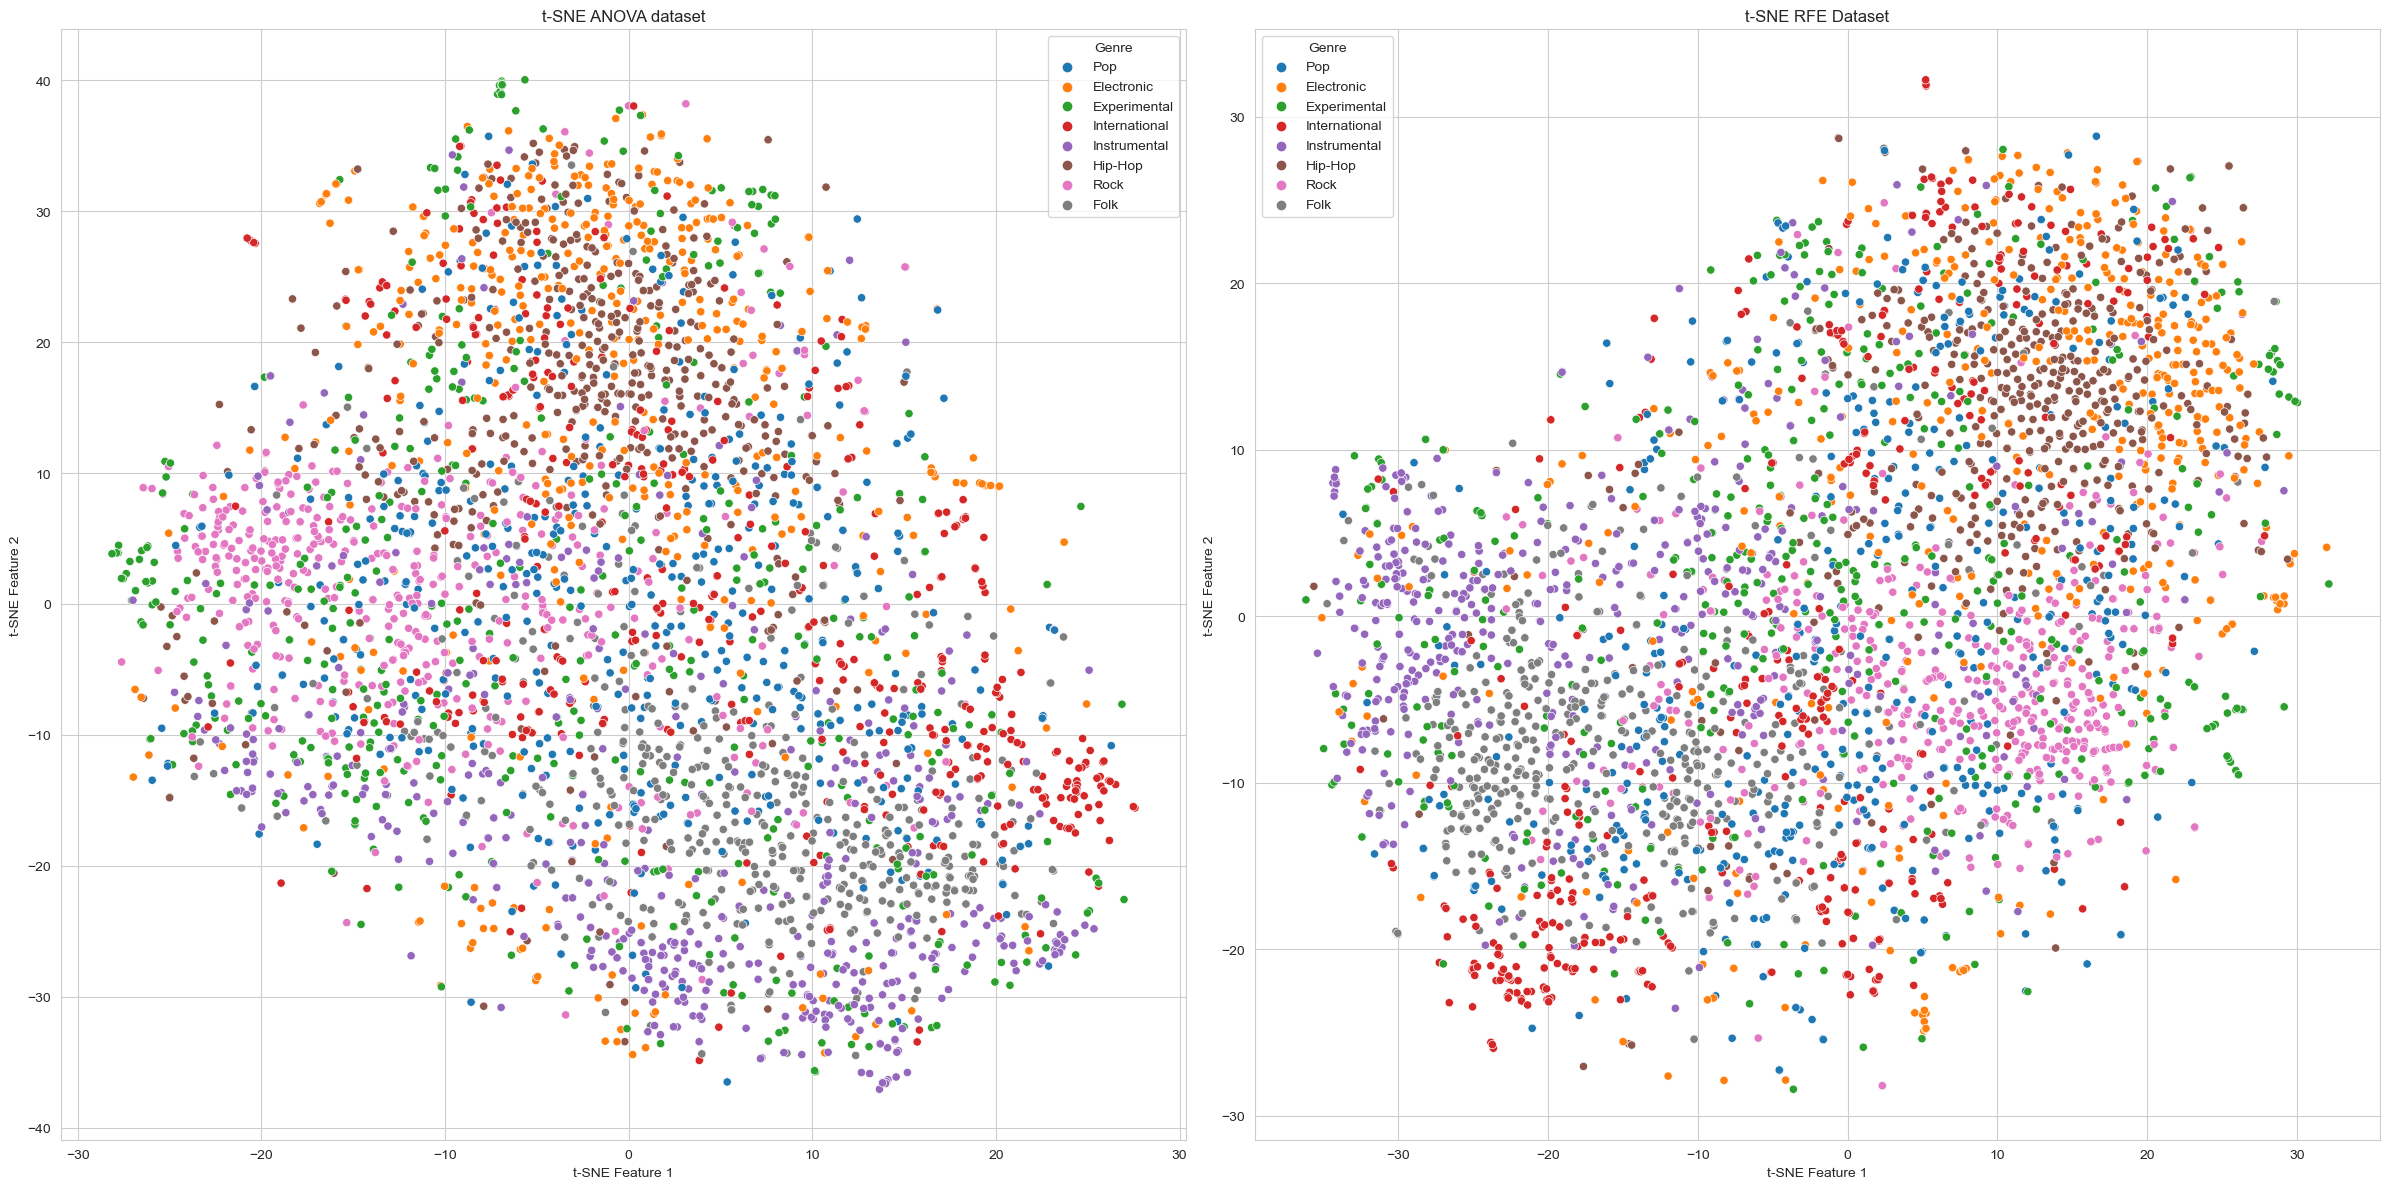

In [110]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot for the first dataset
sns.scatterplot(ax=axes[0], data=X_tsne_anova, x='tsne_1', y='tsne_2', hue='Genre')
axes[0].set_title('t-SNE ANOVA dataset')
axes[0].set_xlabel('t-SNE Feature 1')
axes[0].set_ylabel('t-SNE Feature 2')
axes[0].legend(title='Genre')

# Plot for the second dataset
sns.scatterplot(ax=axes[1], data=X_tsne_RFE, x='tsne_1', y='tsne_2', hue='Genre')
axes[1].set_title('t-SNE RFE Dataset')
axes[1].set_xlabel('t-SNE Feature 1')
axes[1].set_ylabel('t-SNE Feature 2')
axes[1].legend(title='Genre')

# Adjust layout so plots are spaced nicely
plt.tight_layout()
plt.show()

In [57]:
# Initialize and fit UMAP
umap = UMAP(n_neighbors=50, min_dist=0.25, n_components=2, random_state=42)
umap_pca = UMAP(n_neighbors=50, min_dist=0.25, n_components=2, random_state=42)
umap_anova = UMAP(n_neighbors=50, min_dist=0.25, n_components=2, random_state=42)
umap_RFE = UMAP(n_neighbors=50, min_dist=0.25, n_components=2, random_state=42)

# Transform the standardized data
X_umap = umap.fit_transform(X_train_scaled)
X_umap_pca = umap_pca.fit_transform(X_pca)
X_umap_anova = umap_anova.fit_transform(scaler.fit_transform(X_anova))
X_umap_RFE = umap_RFE.fit_transform(X_train_RF)

X_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
X_umap['Genre'] = Y_train_genres

X_umap_pca = pd.DataFrame(X_umap_pca, columns=['UMAP1', 'UMAP2'])
X_umap_pca['Genre'] = Y_train_genres

X_umap_anova = pd.DataFrame(X_umap_anova, columns=['UMAP1', 'UMAP2'])
X_umap_anova['Genre'] = Y_train_genres

X_umap_RFE = pd.DataFrame(X_umap_RFE, columns=['UMAP1', 'UMAP2'])
X_umap_RFE['Genre'] = Y_train_genres

/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/umap/umap_.py:1

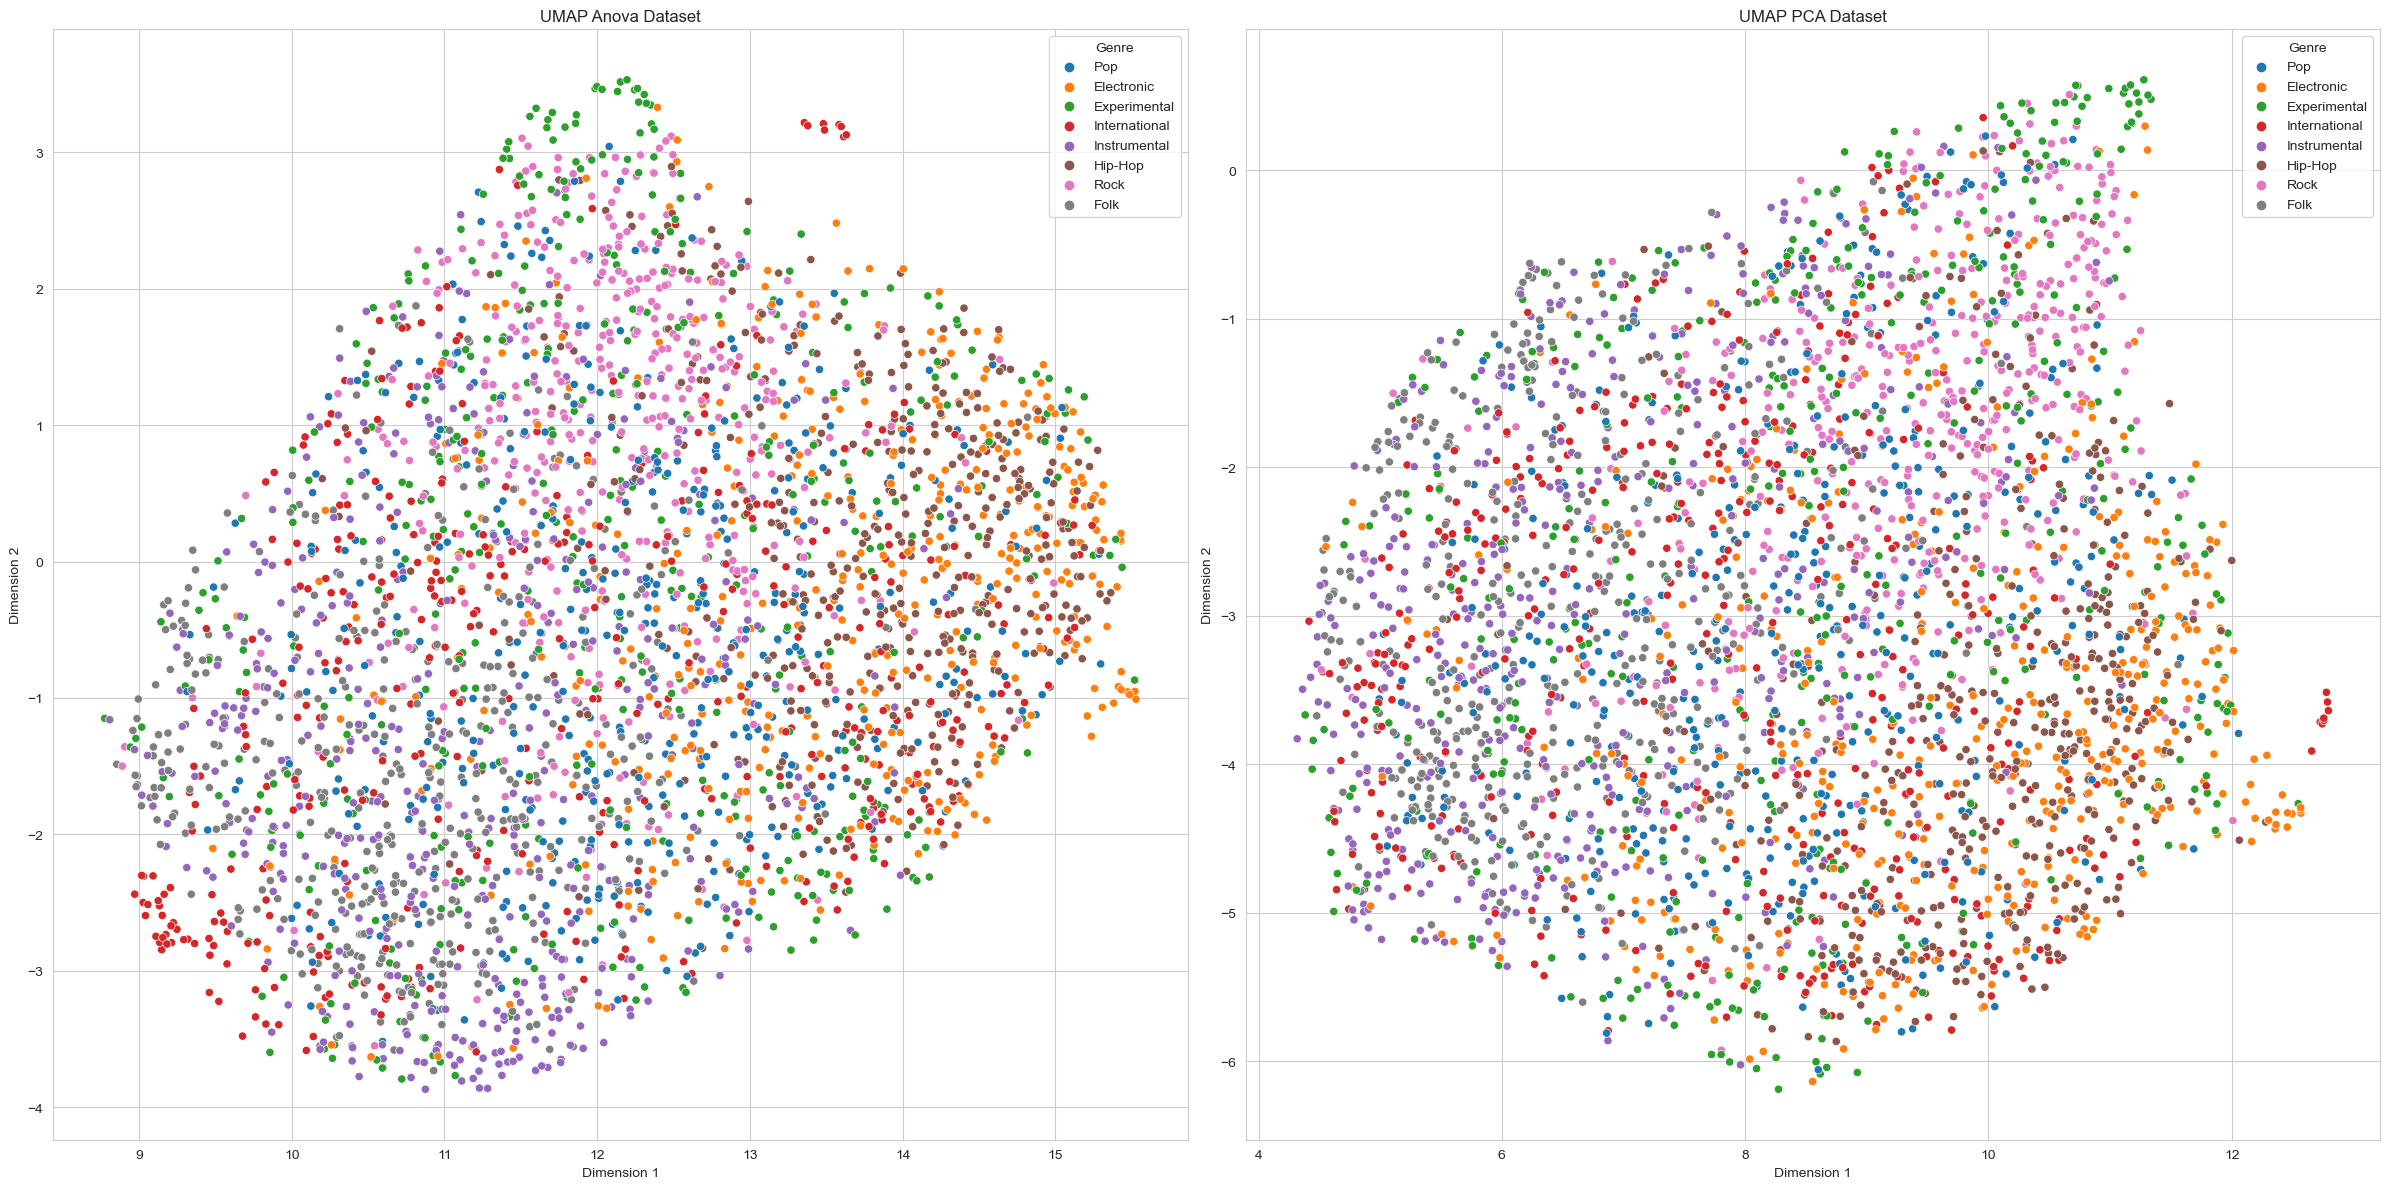

In [117]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot for the first dataset
sns.scatterplot(ax=axes[0], data=X_umap, x='UMAP1', y='UMAP2', hue='Genre')
axes[0].set_title('UMAP Anova Dataset')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].legend(title='Genre')

# Plot for the second dataset
sns.scatterplot(ax=axes[1], data=X_umap_pca, x='UMAP1', y='UMAP2', hue='Genre')
axes[1].set_title('UMAP PCA Dataset')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].legend(title='Genre')

# Adjust layout so plots are spaced nicely
plt.tight_layout()
plt.show()

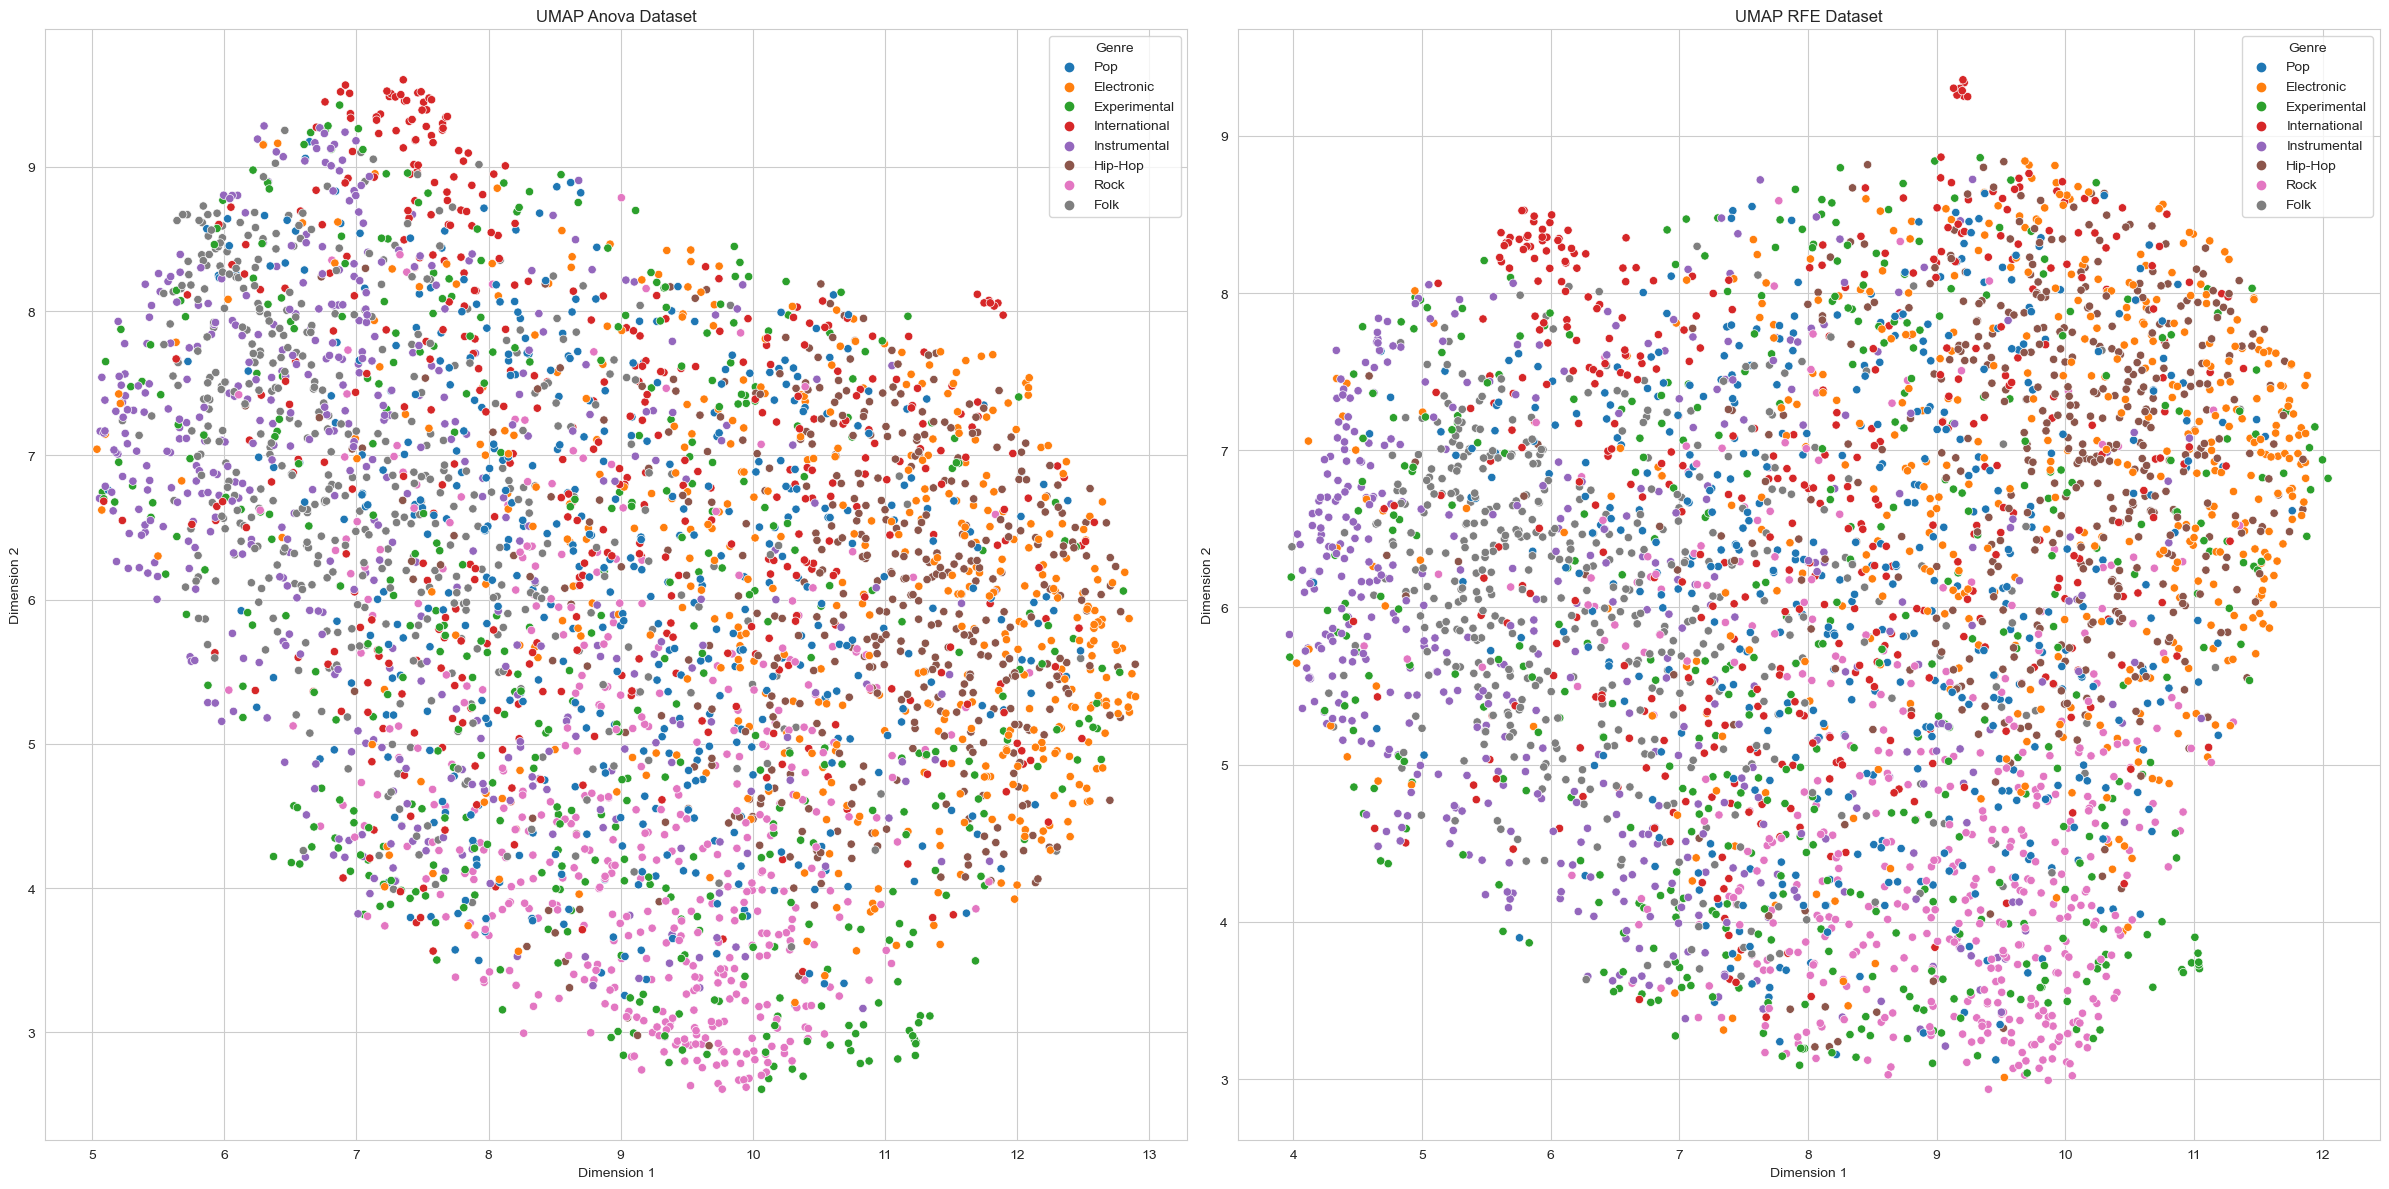

In [112]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot for the first dataset
sns.scatterplot(ax=axes[0], data=X_umap_anova, x='UMAP1', y='UMAP2', hue='Genre')
axes[0].set_title('UMAP Anova Dataset')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].legend(title='Genre')

# Plot for the second dataset
sns.scatterplot(ax=axes[1], data=X_umap_RFE, x='UMAP1', y='UMAP2', hue='Genre')
axes[1].set_title('UMAP RFE Dataset')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].legend(title='Genre')

# Adjust layout so plots are spaced nicely
plt.tight_layout()
plt.show()